# Machine Learning Regresssions
***

#### Table of Contents:
- [Library Imports](#Library-Imports)
- [Preprocessing the Data](#Preprocessing-the-Data)
- [Models](#Models)
    - [Elastic Net](#Elastic-Net)
    - [Support Vector Regression](#Support-Vector-Regression)
    - [Ridge](#Ridge)
- [Looping Through the Data](#Looping-Through-the-Data)
- [Residual Plots](#Residual-Plots)
- [Results](#Results)



### Library Imports
***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge

from os import listdir
from os.path import isfile, join

from scipy.stats import normaltest

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Preprocessing the Data
***

In [2]:
# This function removes highly correlated variables within the dataset. The function looks at the 
# Pearson Correlation Coefficient between every pair of variables in the dataset and returns all 
# of those between .8 and .999. While working with data from different companies, I found that by
# removing the first 90% of correlated variables within the DataFrame, in almost all cases, there
# were no longer correlations within the dataset.

def remove_corrs(df):
    
    # create a DataFrame with all the of the correlation coefficients, and then stack the pairings.
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    # create a temoporary DataFrame that contains all the pairs of variables that have a correlation
    # between .8 and .999. Because the .corr() method returns the pairings in both directions, I only
    # look at half of the cells because of duplicates.
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    # look at how many times each variable shows up in the correlation column
    corr_index = correlations['1'].value_counts().index
    # delete the first 90% of the variables. This generally removes the columns that are most correlated with the others. 
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

In [3]:
# This function preprocesses my data so it is ready for distanced based regressions.

def preprocess_data(df, target_var = 'adjustedclose'):
    
    df.index = pd.to_datetime(df.index)
    
    # Here, I shift all the independent variables back one day in order to make sure there is
    # no data leakage. Because we're trying to predict closing price, we can't know many of
    # things that happen throughout the day we're trying to predict.
    X = df.shift(1).dropna()
    
    # This is the function described above.
    X_data = remove_corrs(X)

    # Because I am running a regression, I can use a continuous variable as my dependent variable.
    # Ideally, my algorithim can predict the closing price at the end of the day with accuracy.
    y = df[target_var].iloc[1:]
    
    # Do a train test split with the first 80% of the data being the training set and the last 20%
    # as the testing set.
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)
    print(train_num, test_num)

    X_train = X_data.iloc[:train_num]
    X_test = X_data.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    # Because I am doing distance based regressions, I need to scale the data so that variables with
    # higher absolute values don't dominate the metrics.
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

## Models
***

### Elastic Net

In [4]:
def EN_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'l1_ratio': [.01,.25,.5,.75,1],
    'alpha': [.01,.25,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    en = ElasticNet(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=en, param_grid=grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error').mean()

    # Score the train and test sets.
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    print(f'Train RMSE: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    print(f'Test RMSE: {test_score}')

    # Create a DataFrame that has the predictions for the given days of the train set.
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    # Compare the direction of the predicted value with what actually happened on the given day.
    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    # Create a DataFrame that has the predictions for the given days of the test set.
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    # Compare the direction of the predicted value with what actually happend on the given day. 
    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)

    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
    
    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')

    results = ['Elastic Net', train_score, cv_results, test_score, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

### Support Vector Regression

In [5]:
def SVR_test(X_train, X_test, y_train, y_test, cv=5):
    
    svr = LinearSVR(random_state = 42, max_iter = 10e5)
    svrmodel = svr.fit(X_train, y_train)
    
    train_score = svr.score(X_train, y_train)
    y_hat_train = svr.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    train_cv_score = cross_val_score(svrmodel, X_train, y_train, scoring = 'neg_root_mean_squared_error').mean()
    
    test_score = svr.score(X_test, y_test)
    y_hat_test = svr.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)
    
    print(f'Train RMSE : {train_rmse}')
    print(f'Mean Train Cross-Validation RMSE: {train_cv_score}')
    print(f'Test RMSE : {test_rmse}')
    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')

    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')

    results = ['SVR', train_score, train_cv_score, test_score, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

### Ridge

In [6]:
def Ridge_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'alpha': [.01, .05, .1,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    ridge = Ridge(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=ridge, param_grid=grid, cv=cv, scoring='r2', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    ridge_params = gs.best_params_
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)

    # Run cross-validate score with cv folds from function parameter
    train_cv_score = cross_val_score(gs, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error').mean()
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.adjustedclose.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.adjustedclose.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)
    
    print(f'Train RMSE : {train_rmse}')
    print(f'Mean Train Cross-Validation RMSE: {train_cv_score}')
    print(f'Test RMSE : {test_rmse}')
    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
 
    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')

    results = ['Ridge', train_rmse, train_cv_score, test_rmse, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

### Looping Through the Data
***

In [7]:
# get the files in the Formatted Data folder.
files = [f for f in listdir('.\FormattedData')]

# create a list of companies that can be analyzed.
companies = []
for i in files:
    company = i.split('.')[0]
    companies.append(company)

# create a list of random companies to analyze from within the formatted companies
test_companies = np.random.choice(companies, 4, replace = False)

In [8]:
# loop through the companies and perform the different alogrithims. Create a
# list of DataFrames that can then be used to compared results across different
# companies and algorithms.

results = []

for c in test_companies:
    csv_for_df = f'FormattedData/{c}.csv'
    df = pd.read_csv(csv_for_df, index_col = 0)
    X_train, X_test, y_train, y_test = preprocess_data(df)
    en_results = EN_test(X_train, X_test, y_train, y_test)
    svr_results = SVR_test(X_train, X_test, y_train, y_test)
    ridge_results = Ridge_test(X_train, X_test, y_train, y_test)
    c_results = pd.DataFrame([en_results, svr_results, ridge_results],
            columns = ['Model Type', 'Train RMSE', 'Cross-Val RMSE', 'Test RMSE', 
             'Train Accuracy', 'Test Accuracy', 'Normality of Residuals'])
    c_results['company'] = c.split('_')[0]
    results.append(c_results)

1798 450
Train RMSE: -1.5951215824248413
Mean Cross-Val Score: -1.9952892821186765
Test RMSE: -5.971752359450751
Train accuracy: 0.4838709677419355
Test accuracy: 0.49333333333333335
Normality score: 6.341970560114359e-102
Train RMSE : 10.330702387087698
Mean Train Cross-Validation RMSE: -15.832077715138468
Test RMSE : 39.71521729405855
Train accuracy: 0.47664071190211343
Test accuracy: 0.4888888888888889
Normality score: 1.2260344910972688e-60
Train RMSE : 1.5857983580178605
Mean Train Cross-Validation RMSE: -1.9262690491128853
Test RMSE : 6.36891544178879
Train accuracy: 0.4972191323692992
Test accuracy: 0.49333333333333335
Normality score: 1.0654473087425105e-103
1798 450
Train RMSE: -3.610247906071548
Mean Cross-Val Score: -4.10285132615391
Test RMSE: -24.373954061510354
Train accuracy: 0.5072302558398221
Test accuracy: 0.4688888888888889
Normality score: 1.355267243370898e-16
Train RMSE : 94.21707837358663
Mean Train Cross-Validation RMSE: -59.583056235260486
Test RMSE : 87.808629

In [19]:
results
tests = pd.concat(results)
tests.to_csv('normregressionresults2.csv')

In [11]:
test_companies2 = np.random.choice(companies, 40, replace = False)
results2 = []

for c in test_companies2:
    csv_for_df = f'FormattedData/{c}.csv'
    df = pd.read_csv(csv_for_df, index_col = 0)
    X_train, X_test, y_train, y_test = preprocess_data(df)
    en_results = EN_test(X_train, X_test, y_train, y_test)
    svr_results = SVR_test(X_train, X_test, y_train, y_test)
    ridge_results = Ridge_test(X_train, X_test, y_train, y_test)
    c_results = pd.DataFrame([en_results, svr_results, ridge_results],
            columns = ['Model Type', 'Train RMSE', 'Cross-Val RMSE', 'Test RMSE', 
             'Train Accuracy', 'Test Accuracy', 'Normality of Residuals'])
    c_results['company'] = c.split('_')[0]
    results2.append(c_results)

1798 450
Train RMSE: -7.2732380361587925
Mean Cross-Val Score: -9.950911998446337
Test RMSE: -43.555778863118505
Train accuracy: 0.5122358175750834
Test accuracy: 0.4955555555555556
Normality score: 6.585342234483029e-24
Train RMSE : 40.173371026961014
Mean Train Cross-Validation RMSE: -80.09657899040397
Test RMSE : 73.61479841965168
Train accuracy: 0.4810901001112347
Test accuracy: 0.4777777777777778
Normality score: 0.0
Train RMSE : 7.209991956709475
Mean Train Cross-Validation RMSE: -9.747775239267757
Test RMSE : 41.43470771654239
Train accuracy: 0.5100111234705228
Test accuracy: 0.4955555555555556
Normality score: 3.307312178382935e-26
1798 450
Train RMSE: -2.607208813351152
Mean Cross-Val Score: -2.3998075066109585
Test RMSE: -9.537705244093328
Train accuracy: 0.4983314794215795
Test accuracy: 0.5155555555555555
Normality score: 5.7610228249214615e-67
Train RMSE : 3.271538820743376
Mean Train Cross-Validation RMSE: -12.151939757520847
Test RMSE : 11.936666241696294
Train accuracy:

In [12]:
test2 = pd.concat(results2)

In [15]:
test2.sort_values('Normality of Residuals', ascending = False)

,Model Type,Train RMSE,Cross-Val RMSE,Test RMSE,Train Accuracy,Test Accuracy,Normality of Residuals,company
2,Ridge,3.726337,-6.632935,22.612843,0.501669,0.464444,0.860186,LYB
0,Elastic Net,-3.739752,-7.130273,-22.999743,0.502781,0.460000,0.834452,LYB
2,Ridge,7.156077,-7.910286,43.632468,0.526696,0.515556,0.558768,CB
1,SVR,0.517678,-27.000135,0.047565,0.492770,0.506667,0.210464,WYNN
2,Ridge,2.377142,-6.126835,13.861756,0.523915,0.511111,0.084516,NLSN
...,...,...,...,...,...,...,...,...
1,SVR,0.511191,-11.027844,-0.913210,0.462736,0.446667,0.000000,CPRT
1,SVR,-1.963134,-1.343248,-19.211040,0.518910,0.632517,0.000000,SEGXF
1,SVR,0.987991,-5.846134,0.984691,0.456618,0.426667,0.000000,ODFL
1,SVR,-22.577770,-18.369740,-94.570028,0.520578,0.568889,0.000000,CNP


In [17]:
test2.to_csv('normregressionresults.csv')

NameError: name 'y_hat_train' is not defined

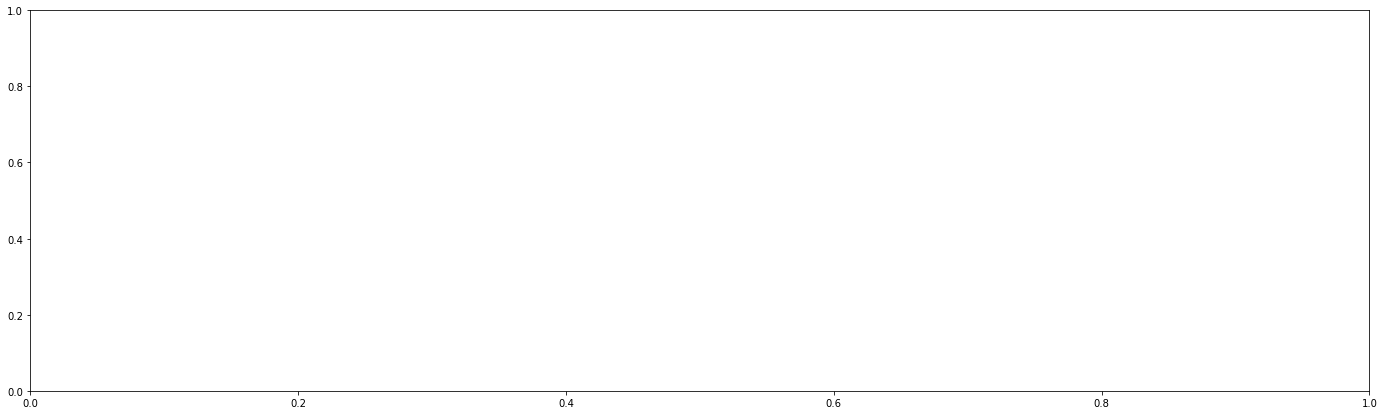

In [10]:
fig, ax = plt.subplots(figsize = (24,7))
plot_x = y_train.index
plot_y = (y_hat_train - y_train)/y_train
plt.scatter(plot_x,plot_y)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

In [ ]:
fig2, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = 1, color = 'red');

In [ ]:
fig3, ax = plt.subplots(figsize = (24,7))
fig3_data = preds_test[(preds_test.index >= '1-1-2020') & (preds_test.index <= '4-1-2021')]
ax.plot(fig3_data.adjustedclose, linewidth = 3.0)
ax.plot(fig3_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');

In [ ]:
fig4, ax = plt.subplots(figsize = (24,7))
fig4_data = preds_train[(preds_train.index >= '1-1-2018') & (preds_train.index <= '1-1-2020')]
ax.plot(fig4_data.adjustedclose, linewidth = 3.0)
ax.plot(fig4_data.predictions)
ax.yaxis.set_major_formatter('${x:1,.2f}');